In [41]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.feature_selection import mutual_info_regression

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import mutual_info_regression
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor







pd.set_option('display.max_columns', None)

data = pd.read_excel('nba_player_data.xlsx')

In [2]:
data.sample(100)

,Year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,EFF,AST_TOV,STL_TOV
1726,2014-15,Regular%20Season,203508,365,Sergey Karasev,BKN,33,555,54,134,0.403,16,54,0.296,29,38,0.763,22,44,66,46,23,1,24,45,153,176,1.92,0.96
5571,2019-20,Playoffs,1628365,97,Markelle Fultz,ORL,5,147,24,60,0.400,6,16,0.375,6,7,0.857,0,11,11,26,5,3,13,20,60,55,2.00,0.39
2066,2015-16,Regular%20Season,203081,5,Damian Lillard,POR,75,2676,618,1474,0.419,229,610,0.375,414,464,0.892,45,257,302,512,65,28,242,165,1879,1638,2.12,0.27
3377,2016-17,Playoffs,1626153,138,Delon Wright,TOR,9,92,9,17,0.529,2,6,0.333,5,7,0.714,4,9,13,13,4,1,5,4,25,41,2.60,0.80
1445,2014-15,Regular%20Season,101139,84,CJ Miles,IND,70,1841,329,827,0.398,154,446,0.345,130,161,0.807,18,196,214,75,60,26,73,132,942,715,1.03,0.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6893,2021-22,Regular%20Season,1626246,423,Boban Marjanovic,DAL,23,128,42,70,0.600,1,4,0.250,13,22,0.591,8,31,39,3,0,3,15,24,98,91,0.20,0.00
6430,2020-21,Playoffs,1629726,196,Garrison Mathews,WAS,3,17,0,4,0.000,0,4,0.000,4,5,0.800,0,2,2,0,0,0,0,4,4,1,0.00,0.00
6993,2021-22,Regular%20Season,1630612,522,RJ Nembhard Jr.,CLE,14,63,6,18,0.333,0,2,0.000,3,4,0.750,3,4,7,12,1,0,3,2,15,19,4.00,0.33
4099,2017-18,Playoffs,203490,106,Otto Porter Jr.,WAS,5,158,20,41,0.488,5,12,0.417,5,8,0.625,1,24,25,8,6,5,3,6,50,67,2.67,2.00


In [3]:
data.shape

(7293, 29)

# Data cleaning & analysis preparation

In [4]:
data.isna().sum()

Year           0
Season_type    0
PLAYER_ID      0
RANK           0
PLAYER         0
TEAM           0
GP             0
MIN            0
FGM            0
FGA            0
FG_PCT         0
FG3M           0
FG3A           0
FG3_PCT        0
FTM            0
FTA            0
FT_PCT         0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
PF             0
PTS            0
EFF            0
AST_TOV        0
STL_TOV        0
dtype: int64

In [5]:
data.drop(columns=['RANK','EFF'], inplace=True)
# after turn string into int, we name it season_start_year
data['season_start_year'] = data['Year'].str[:4].astype(int)
data['TEAM'].replace(to_replace=['NOP','NOH'], value='NO', inplace=True)
data['Season_type'].replace('Regular%20Season','RS', inplace=True)
rs_df = data[data['Season_type']=='RS']
playoffs_df = data[data['Season_type']=='Playoffs']
data.columns

Index(['Year', 'Season_type', 'PLAYER_ID', 'PLAYER', 'TEAM', 'GP', 'MIN',
       'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA',
       'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'AST_TOV', 'STL_TOV', 'season_start_year'],
      dtype='object')

In [6]:
data

,Year,Season_type,PLAYER_ID,PLAYER,TEAM,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,AST_TOV,STL_TOV,season_start_year
0,2012-13,RS,201142,Kevin Durant,OKC,81,3119,731,1433,0.510,139,334,0.416,679,750,0.905,46,594,640,374,116,105,280,143,2280,1.34,0.41,2012
1,2012-13,RS,977,Kobe Bryant,LAL,78,3013,738,1595,0.463,132,407,0.324,525,626,0.839,66,367,433,469,106,25,287,173,2133,1.63,0.37,2012
2,2012-13,RS,2544,LeBron James,MIA,76,2877,765,1354,0.565,103,254,0.406,403,535,0.753,97,513,610,551,129,67,226,110,2036,2.44,0.57,2012
3,2012-13,RS,201935,James Harden,HOU,78,2985,585,1337,0.438,179,486,0.368,674,792,0.851,62,317,379,455,142,38,295,178,2023,1.54,0.48,2012
4,2012-13,RS,2546,Carmelo Anthony,NYK,67,2482,669,1489,0.449,157,414,0.379,425,512,0.830,134,326,460,171,52,32,175,205,1920,0.98,0.30,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7288,2021-22,Playoffs,1629006,Josh Okogie,MIN,1,2,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,0,0,0,0,0,0,0.00,0.00,2021
7289,2021-22,Playoffs,1630556,Kessler Edwards,BKN,2,7,0,0,0.000,0,0,0.000,0,0,0.000,0,0,0,1,1,0,1,3,0,1.00,1.00,2021
7290,2021-22,Playoffs,1630201,Malachi Flynn,TOR,6,36,0,7,0.000,0,3,0.000,0,0,0.000,2,1,3,3,1,0,1,6,0,3.00,1.00,2021
7291,2021-22,Playoffs,202693,Markieff Morris,MIA,2,3,0,1,0.000,0,0,0.000,0,0,0.000,0,1,1,0,0,0,1,2,0,0.00,0.00,2021


In [7]:
total_cols = ['MIN','FGM','FGA','FG3M','FG3A','FTM','FTA',
              'OREB','DREB','REB','AST','STL','BLK','TOV','PF','PTS']

In [8]:
corr_matrix = data.corr()
corr_matrix

/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/184011309.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


,PLAYER_ID,GP,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,AST_TOV,STL_TOV,season_start_year
PLAYER_ID,1.000000,-0.123665,-0.160812,-0.137554,-0.139728,-0.044359,-0.063209,-0.057878,0.011896,-0.144029,-0.146257,-0.103690,-0.118451,-0.140710,-0.138966,-0.124454,-0.140518,-0.100507,-0.150331,-0.144051,-0.136810,-0.018408,0.011474,0.574698
GP,-0.123665,1.000000,0.905608,0.789848,0.796535,0.217880,0.617089,0.639598,0.203980,0.639904,0.660181,0.345681,0.631183,0.776140,0.760203,0.636788,0.787656,0.579758,0.753761,0.900406,0.777601,0.144630,0.079466,-0.102255
MIN,-0.160812,0.905608,1.000000,0.935088,0.940743,0.200545,0.728095,0.748195,0.229306,0.802258,0.814633,0.338089,0.651454,0.861414,0.829745,0.777331,0.890922,0.610058,0.887284,0.917585,0.929248,0.161256,0.038046,-0.086147
FGM,-0.137554,0.789848,0.935088,1.000000,0.989459,0.212113,0.713755,0.730225,0.214321,0.895489,0.898680,0.313388,0.628332,0.849227,0.814045,0.788669,0.830690,0.589914,0.918063,0.832574,0.993742,0.120812,-0.032905,-0.041261
FGA,-0.139728,0.796535,0.940743,0.989459,1.000000,0.163044,0.769594,0.791253,0.242616,0.888476,0.882753,0.330974,0.559782,0.812269,0.766880,0.810013,0.844514,0.530731,0.923041,0.823042,0.991104,0.142703,-0.025393,-0.050273
FG_PCT,-0.044359,0.217880,0.200545,0.212113,0.163044,1.000000,0.026541,0.015603,0.150446,0.170257,0.195832,0.188619,0.312947,0.262171,0.285202,0.100443,0.152606,0.280728,0.167697,0.246865,0.192359,0.019698,0.070350,0.023296
FG3M,-0.063209,0.617089,0.728095,0.713755,0.769594,0.026541,1.000000,0.992040,0.387790,0.594705,0.548579,0.328327,0.133505,0.477402,0.395030,0.639617,0.659748,0.186129,0.646404,0.571964,0.757302,0.195808,0.047404,0.078814
FG3A,-0.057878,0.639598,0.748195,0.730225,0.791253,0.015603,0.992040,1.000000,0.375069,0.618485,0.574868,0.334657,0.147951,0.496640,0.413532,0.665279,0.685530,0.200059,0.675136,0.593905,0.773190,0.201529,0.048826,0.081333
FG3_PCT,0.011896,0.203980,0.229306,0.214321,0.242616,0.150446,0.387790,0.375069,1.000000,0.155608,0.125497,0.292931,-0.083778,0.094308,0.046656,0.225072,0.218278,-0.032831,0.184881,0.149306,0.232953,0.258865,0.123466,0.108059
FTM,-0.144029,0.639904,0.802258,0.895489,0.888476,0.170257,0.594705,0.618485,0.155608,1.000000,0.987628,0.286228,0.537560,0.750768,0.714559,0.757236,0.739736,0.513849,0.880927,0.703658,0.924384,0.089693,-0.069042,-0.060002


In [9]:
data_per_min = data.groupby(['PLAYER','PLAYER_ID','Year'])[total_cols].sum().reset_index()
for col in data_per_min.columns[4:]:
    data_per_min[col] = data_per_min[col]/data_per_min['MIN']

data_per_min['FG%'] = data_per_min['FGM']/data_per_min['FGA']
data_per_min['3PT%'] = data_per_min['FG3M']/data_per_min['FG3A']
data_per_min['FT%'] = data_per_min['FTM']/data_per_min['FTA']
data_per_min['FG3A%'] = data_per_min['FG3A']/data_per_min['FGA']
data_per_min['PTS/FGA'] = data_per_min['PTS']/data_per_min['FGA']
data_per_min['FG3M/FGM'] = data_per_min['FG3M']/data_per_min['FGM']
data_per_min['FTA/FGA'] = data_per_min['FTA']/data_per_min['FGA']
data_per_min['TRU%'] = 0.5*data_per_min['PTS']/(data_per_min['FGA']+0.475*data_per_min['FTA']) # true shooting percentage
data_per_min['AST_TOV'] = data_per_min['AST']/data_per_min['TOV']


data_per_min = data_per_min[data_per_min['MIN']>=50]
data_per_min.drop(columns='PLAYER_ID', inplace=True)
data_per_min

correlation_matrix = data_per_min.corr()

fig = px.imshow(correlation_matrix)
fig.show()

/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/444219878.py:20: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_per_min.corr()


Another dataset we get from web

In [10]:
master_table = pd.read_csv('master_table.csv')
master_table.head(10)

,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,year,team,W,W/L%,seed,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player
0,1,Kareem Abdul-Jabbar,32,LAL,147.0,147.0,221,0.665,82,38.3,24.8,10.8,4.5,1.0,3.4,0.604,0.000,0.765,14.8,0.227,1980,Los Angeles Lakers,60.0,0.732,1.0,25.3,0.639,0.001,0.344,7.2,22.2,15.4,16.5,1.2,4.6,15.7,24.1,9.5,5.3,14.8,0.227,4.8,2.4,7.2,7.3
1,2,Julius Erving,29,PHI,31.5,31.5,221,0.143,78,36.1,26.9,7.4,4.6,2.2,1.8,0.519,0.200,0.787,12.5,0.213,1980,Philadelphia 76ers,59.0,0.720,2.0,25.4,0.568,0.012,0.331,8.6,12.9,10.9,21.4,2.8,2.7,13.3,30.3,7.3,5.2,12.5,0.213,5.7,1.9,7.6,6.8
2,3,George Gervin,27,SAS,19.0,19.0,221,0.086,78,37.6,33.1,5.2,2.6,1.4,1.0,0.528,0.314,0.852,10.6,0.173,1980,San Antonio Spurs,41.0,0.500,4.5,24.0,0.587,0.053,0.306,5.7,8.9,7.3,11.0,1.6,1.4,10.3,31.7,9.3,1.3,10.6,0.173,5.5,-1.6,3.9,4.4
3,4,Larry Bird,23,BOS,15.0,15.0,221,0.068,82,36.0,21.3,10.4,4.5,1.7,0.6,0.474,0.406,0.836,11.2,0.182,1980,Boston Celtics,61.0,0.744,1.0,20.5,0.538,0.098,0.246,8.3,23.6,16.0,18.5,2.3,1.0,14.0,25.3,5.6,5.6,11.2,0.182,3.0,1.5,4.5,4.8
4,5T,Tiny Archibald,31,BOS,2.0,2.0,221,0.009,80,35.8,14.1,2.5,8.4,1.3,0.1,0.482,0.222,0.830,8.9,0.148,1980,Boston Celtics,61.0,0.744,1.0,15.3,0.574,0.023,0.548,2.3,5.3,3.8,30.2,1.7,0.2,19.7,17.0,5.9,2.9,8.9,0.148,1.4,-0.3,1.1,2.3
5,5T,Dennis Johnson,25,SEA,2.0,2.0,221,0.009,81,36.3,19.0,5.1,4.1,1.8,1.0,0.422,0.207,0.780,7.4,0.120,1980,Seattle SuperSonics,56.0,0.683,2.0,15.9,0.489,0.043,0.358,6.2,8.7,7.4,16.1,2.3,1.5,12.6,24.2,3.0,4.4,7.4,0.120,0.5,0.8,1.3,2.5
6,5T,Dan Roundfield,26,ATL,2.0,2.0,221,0.009,81,32.0,16.5,10.3,2.3,1.2,1.7,0.499,0.000,0.710,9.1,0.169,1980,Atlanta Hawks,50.0,0.610,3.0,19.7,0.551,0.004,0.462,12.1,22.7,17.3,11.3,1.9,3.2,16.1,22.8,4.0,5.1,9.1,0.169,1.6,1.4,2.9,3.2
7,8,Gus Williams,26,SEA,1.5,1.5,221,0.007,82,36.2,22.1,3.4,4.8,2.4,0.5,0.482,0.194,0.788,11.6,0.187,1980,Seattle SuperSonics,56.0,0.683,2.0,20.6,0.529,0.023,0.274,4.5,5.3,4.9,20.7,3.2,0.7,9.5,25.2,7.2,4.4,11.6,0.187,3.1,1.6,4.7,5.0
8,9,Moses Malone,24,HOU,1.0,1.0,221,0.005,82,38.3,25.8,14.5,1.8,1.0,1.3,0.502,0.000,0.719,11.9,0.183,1980,Houston Rockets,41.0,0.500,4.5,24.1,0.560,0.004,0.505,19.6,22.3,20.9,7.1,1.2,1.9,13.7,27.6,8.9,3.0,11.9,0.183,4.5,-2.4,2.1,3.2
9,1,Julius Erving,30,PHI,28.0,454.0,690,0.658,82,35.0,24.6,8.0,4.4,2.1,1.8,0.521,0.222,0.787,13.8,0.231,1981,Philadelphia 76ers,62.0,0.756,1.5,25.1,0.572,0.012,0.352,10.0,14.6,12.5,19.8,2.8,2.8,13.1,28.4,7.8,6.1,13.8,0.231,5.2,2.3,7.5,6.9


In [11]:

def calculate_ml_scores(df):
    X = df.copy()
    y = X["Share"]

    X.drop('Share', axis=1, inplace=True)

    # Label encoding for categoricals
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()

    # All discrete features should now have integer dtypes (double-check this before using MI!)
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return X, y, mi_scores

In [12]:
master_table_mi = master_table.copy()
master_table_mi.drop(['Rank','Player','Age','year','Tm','team','First','Pts Won','Pts Max','WS','WS/48'], axis=1, inplace=True)
X, y, mi_scores = calculate_ml_scores(df=master_table_mi)

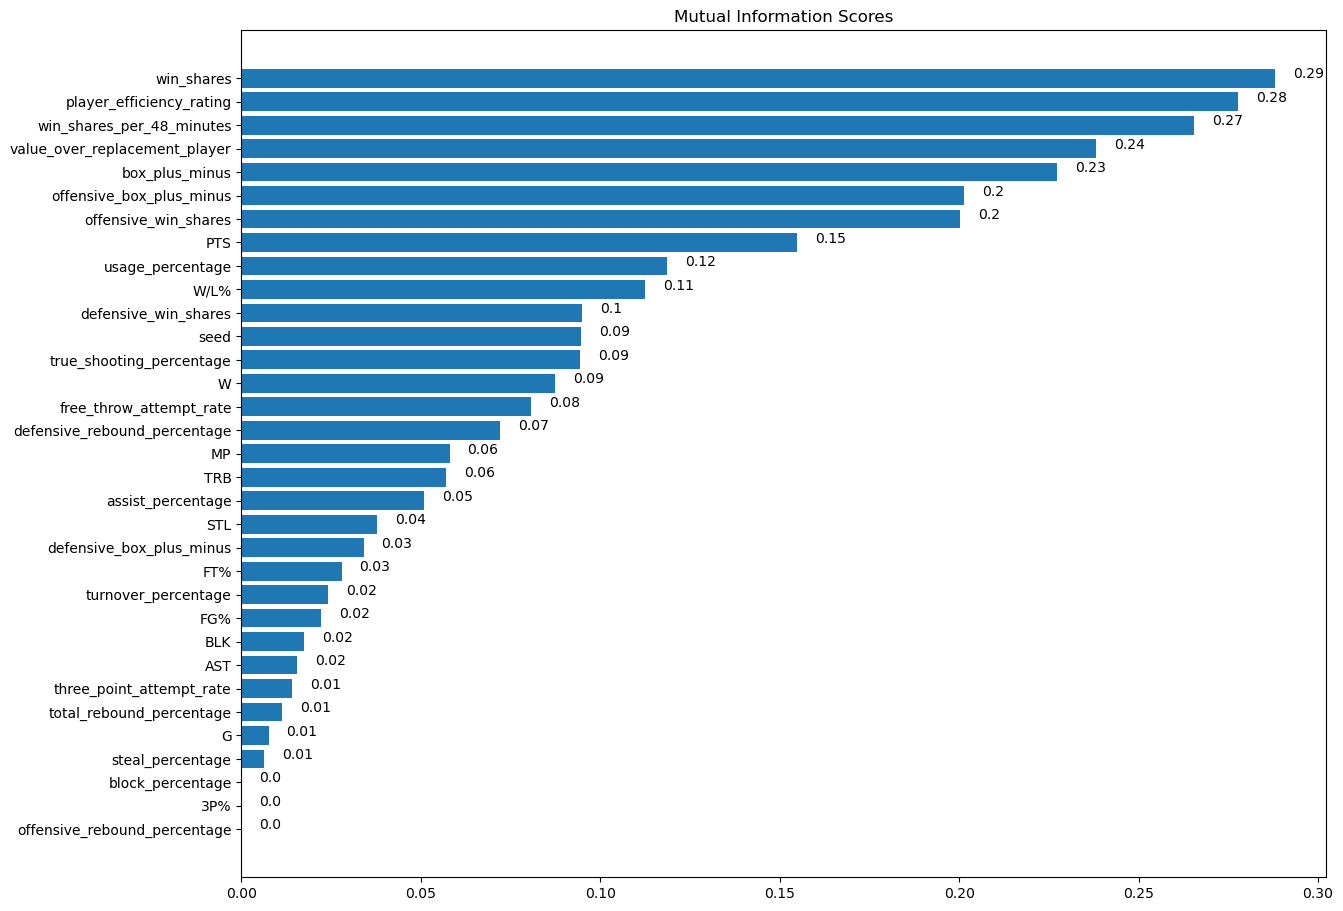

In [13]:
def plot_mi_scores(scores, figsize):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(width, scores)
    
    for index, value in enumerate(scores):
        plt.text(value +0.005 , index, str(round(value,2)))
    
    plt.yticks(width, ticks)    
    plt.title("Mutual Information Scores")

plot_mi_scores(mi_scores, figsize=(14,11))

In [14]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [15]:
to_drop = [
    'Rank',
    'Player',
    'Age',
    'year',
    'Tm',
    'team',
    'First',
    'Pts Won',
    'Pts Max',
    'WS/48',
    'WS',
    'MP',
    'G',
    'W', 
    'FG%',
    '3P%',
    'STL', 
    'BLK',
    'three_point_attempt_rate',
    'total_rebound_percentage',
    'offensive_rebound_percentage',
    'block_percentage',
    'defensive_rebound_percentage',
    'steal_percentage',
    'turnover_percentage',
    'assist_percentage',
    'AST',
    'TRB',
    #'free_throw_attempt_rate', ######### Experiment
    'FT%',
    'win_shares', 
    #'value_over_replacement_player', 
    'box_plus_minus', 
    #'offensive_box_plus_minus', 
    'defensive_box_plus_minus',
    'offensive_win_shares', 
    'defensive_win_shares', 
    'true_shooting_percentage' 
]

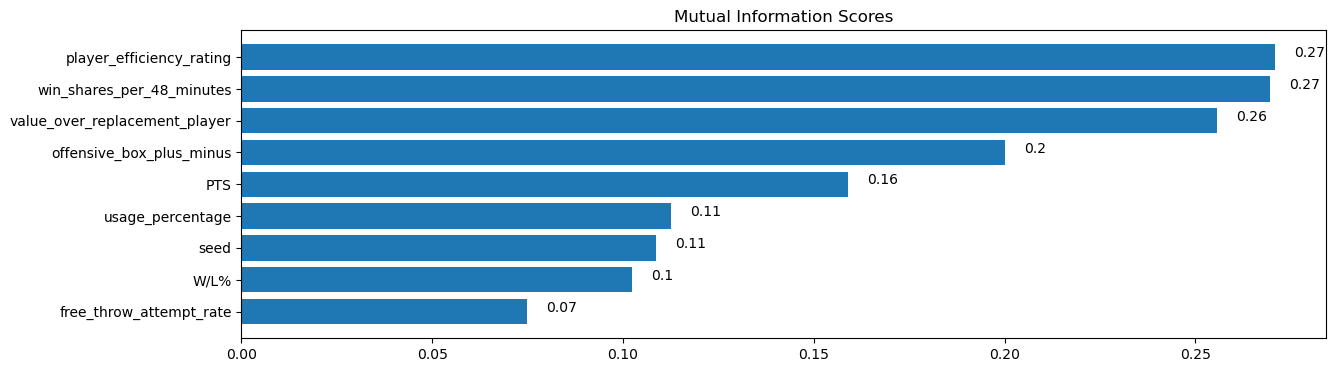

In [16]:
master_table_mi2 = master_table.copy()
master_table_mi2.drop(to_drop, axis=1, inplace=True)
X, y, mi_scores2 = calculate_ml_scores(df=master_table_mi2)
plot_mi_scores(mi_scores2, figsize=(14,4))

In [29]:
y = master_table['win_shares']

def train_test_split_by_year(year, df, scaling=False):
    #test year = selected year, train year = other years outside of selected year
    train_df = df[df['year'] != year]
    test_df = df[df['year'] == year]
    
    train_df2 = train_df.copy()
    test_df2 = test_df.copy()
    
    train_df2.drop(to_drop, axis=1, inplace=True)
    test_df2.drop(to_drop, axis=1, inplace=True)
    
    if scaling == True:
        sc_X = StandardScaler()
        sc_y = StandardScaler()
        train_df2 = sc_X.fit_transform(train_df2)
        test_df2 = sc_y.fit_transform(test_df2)
    
    X_train = train_df2.copy()
    y_train = X_train["Share"]
    
    X_test = test_df2.copy()
    y_test = X_test["Share"]

    X_train.drop('Share', axis=1, inplace=True)
    cols = X_train.columns
    X_test.drop('Share', axis=1, inplace=True)

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    return X_train, y_train, X_test, y_test, cols




def run_model(regressor, X_train, y_train, X_test, y_test, df, year):
    model = regressor
    model.fit(X_train, y_train) 
    predictions = model.predict(X_test)
    mae = mean_absolute_error(predictions, y_test)
    r2 = r2_score(y_test, predictions)
    
    mvp_race = df[df['year'] == year]
    mvp_race['predicted_share'] = predictions
    mvp_race = mvp_race.sort_values(["Share", "predicted_share"], ascending = (False, False))
                                    
    actual_winner = mvp_race[mvp_race['Share'] == mvp_race['Share'].max()]['Player']
    predicted_winner = mvp_race[mvp_race['predicted_share'] == mvp_race['predicted_share'].max()]['Player']
    return model, mae, r2, predicted_winner.iloc[0], actual_winner.iloc[0], mvp_race

In [30]:
years = [year for year in range(1980, 2022)]

def run_model_average(df, regressor, scaling=False, print_metrics=False):
    mae_lst = []
    r2_lst = []
    predicted_lst = []
    actual_lst = []
    label_lst =[]
    model_lst = []
    for year in tqdm(years):
        X_train, y_train, X_test, y_test, cols = train_test_split_by_year(year=year, df=df, scaling=False)
        model, mae, r2, predicted_winner, actual_winner, mvp_race = run_model(regressor,
                                                             X_train,
                                                              y_train,
                                                              X_test,
                                                              y_test,
                                                              df=df,
                                                              year=year,
                                                            )
        if predicted_winner == actual_winner:
            label = 'correct'
        else:
            label = 'incorrect'
        mae_lst.append(mae)
        r2_lst.append(r2)
        predicted_lst.append(predicted_winner)
        actual_lst.append(actual_winner)
        label_lst.append(label)
        model_lst.append(model)
    d = {
    'year': years,
    'MAE': mae_lst,
    'R squared': r2_lst,
    'Predicted MVP': predicted_lst,
    'Actual MVP': actual_lst,
    'Label': label_lst
    }

    summary = pd.DataFrame(d)
    correct_count = summary['Label'].value_counts().iloc[0]
    incorrect_count = summary['Label'].value_counts().iloc[1]
    accuracy = correct_count / (correct_count + incorrect_count)
    avg_mae = summary['MAE'].mean()
    avg_r2  = summary['R squared'].mean()
    
    if print_metrics == True:
        print(f"Average MAE: {avg_mae}")
        print(f"Average R squared: {avg_r2}")
        print(f"Prediction accuracy: {accuracy}")
    return avg_mae, avg_r2, accuracy, summary, model_lst, cols

In [31]:
lr_avg_mae, lr_avg_r2, lr_accuracy, lr_summary, lr_models, cols = run_model_average(df=master_table,
                  regressor = LinearRegression(),
                 scaling=True,
                print_metrics=True)


  0%|          | 0/42 [00:00<?, ?it/s]/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

Average MAE: 0.14528095583827477
Average R squared: 0.47169459188854956
Prediction accuracy: 0.6428571428571429


In [76]:
lr_summary


,year,MAE,R squared,Predicted MVP,Actual MVP,Label
0,1980,0.121849,0.441512,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,correct
1,1981,0.123743,0.122795,Julius Erving,Julius Erving,correct
2,1982,0.113224,0.260997,Julius Erving,Moses Malone,incorrect
3,1983,0.121046,0.361587,Larry Bird,Moses Malone,incorrect
4,1984,0.127985,0.401172,Larry Bird,Larry Bird,correct
5,1985,0.106180,0.556219,Larry Bird,Larry Bird,correct
6,1986,0.115069,0.518078,Larry Bird,Larry Bird,correct
7,1987,0.095123,0.659895,Michael Jordan,Magic Johnson,incorrect
8,1988,0.142444,0.570344,Michael Jordan,Michael Jordan,correct
9,1989,0.106765,0.657597,Michael Jordan,Magic Johnson,incorrect


The accuracy is:  0.6428571428571429


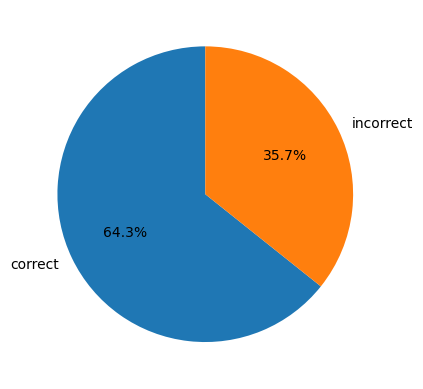

In [72]:

alist2 = ['correct', 'incorrect']
a2 = 0
b2 = 0
for i in lr_summary['Label']:
    if i == 'correct':
        a2 = a2 + 1
    if i == 'incorrect':
        b2 = b2 + 1
blist2 = [a2, b2]

def addlabels(x,y):
    for i in range(len(alist2)):
        plt.text(i,y[i],y[i])



#addlabels(alist2, blist2)

plt.pie(blist2, labels=alist2, autopct='%1.1f%%', startangle=90)
print('The accuracy is: ' ,+  lr_accuracy)

In [32]:
#display feature importance for tree algorithms (RF, XGB, LGBM
def avg_feature_importance(models, cols):
    lst = []
    for model in models:
        feature_importance = list(model.feature_importances_)
        lst.append(feature_importance)
        
    df = pd.DataFrame(lst, columns=cols)
    mean_features = df.mean()
    
    #df2 = pd.DataFrame([cols ,mean_features], columns=['Feature', 'Feature Importance'])
    df2 = pd.DataFrame([cols ,mean_features]).T
    df2 = df2.rename(columns={0:'Feature', 1:'Score'}).sort_values(by='Score', ascending=False)
    
    #plt.rcParams["figure.figsize"] = (7,4)
    plt.title('Feature Importance Score')
    sns.barplot(x='Score',
                y= 'Feature',
               data=df2,
                  )
    plt.show()


In [33]:
rf_avg_mae, rf_avg_r2, rf_accuracy, rf_summary, rf_models, rf_cols = run_model_average(df=master_table,
                  regressor=RandomForestRegressor(n_estimators = 23, 
                                                  random_state = 0, 
                                                  max_depth=7, 
                                                  min_samples_leaf=1,
                                                  min_samples_split=2),
                print_metrics=True)

  0%|          | 0/42 [00:00<?, ?it/s]/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|▏         | 1/42 [00:00<00:07,  5.39it/s]/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.


Average MAE: 0.10402398323666445
Average R squared: 0.6079918227884215
Prediction accuracy: 0.7380952380952381


In [67]:
rf_summary


,year,MAE,R squared,Predicted MVP,Actual MVP,Label
0,1980,0.079448,0.455068,Julius Erving,Kareem Abdul-Jabbar,incorrect
1,1981,0.056070,0.492895,Julius Erving,Julius Erving,correct
2,1982,0.078858,0.249830,Magic Johnson,Moses Malone,incorrect
3,1983,0.077223,0.463951,Moses Malone,Moses Malone,correct
4,1984,0.088231,0.598126,Larry Bird,Larry Bird,correct
5,1985,0.051532,0.829108,Larry Bird,Larry Bird,correct
6,1986,0.078970,0.715807,Larry Bird,Larry Bird,correct
7,1987,0.071625,0.757898,Magic Johnson,Magic Johnson,correct
8,1988,0.076710,0.770080,Michael Jordan,Michael Jordan,correct
9,1989,0.056553,0.881297,Magic Johnson,Magic Johnson,correct


The accuracy is:  0.7380952380952381


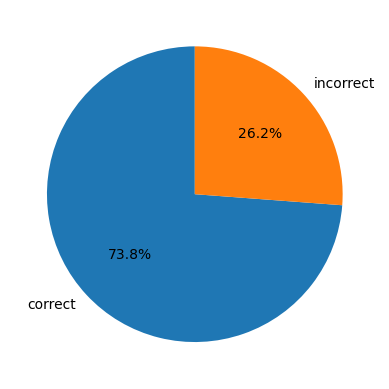

In [73]:

alist1 = ['correct', 'incorrect']
a1 = 0
b1 = 0
for i in rf_summary['Label']:
    if i == 'correct':
        a1 = a1 + 1
    if i == 'incorrect':
        b1 = b1 + 1
blist1 = [a1, b1]

def addlabels(x,y):
    for i in range(len(alist1)):
        plt.text(i,y[i],y[i])



plt.pie(blist1, labels=alist1, autopct='%1.1f%%', startangle=90)

print('The accuracy is: ' ,+  rf_accuracy)

In [38]:
xgb_avg_mae, xgb_avg_r2, xgb_accuracy, xgb_summary, xgb_models, xgb_cols = run_model_average(df=master_table,
                  regressor = XGBRegressor(n_estimators=32, max_depth=6, learning_rate = 0.1, subsample=1, colsample_bytree=1),
                 scaling=False, print_metrics=True)

  0%|          | 0/42 [00:00<?, ?it/s]/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  2%|▏         | 1/42 [00:00<00:10,  3.91it/s]/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  5%|▍         | 2/42 [00:00<00:12,  3.17it/s]/var/folders/59/dqp_1kp50xv990hpbt41lcv80000gn/T/ipykernel_1465/483298017.py:48: SettingWithCopyWarning:


A value is trying to 

Average MAE: 0.10742067563118333
Average R squared: 0.586598086831461
Prediction accuracy: 0.7619047619047619


In [68]:
xgb_summary

,year,MAE,R squared,Predicted MVP,Actual MVP,Label
0,1980,0.065370,0.705317,Kareem Abdul-Jabbar,Kareem Abdul-Jabbar,correct
1,1981,0.047880,0.604429,Julius Erving,Julius Erving,correct
2,1982,0.079301,0.214354,Magic Johnson,Moses Malone,incorrect
3,1983,0.083553,0.364133,Moses Malone,Moses Malone,correct
4,1984,0.108430,0.441085,Larry Bird,Larry Bird,correct
5,1985,0.054356,0.835082,Larry Bird,Larry Bird,correct
6,1986,0.087208,0.710427,Larry Bird,Larry Bird,correct
7,1987,0.079707,0.686136,Magic Johnson,Magic Johnson,correct
8,1988,0.094884,0.693052,Michael Jordan,Michael Jordan,correct
9,1989,0.064443,0.845739,Magic Johnson,Magic Johnson,correct


The accuracy is:  0.7619047619047619


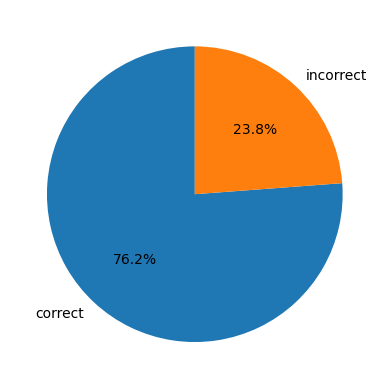

In [74]:


alist = ['correct', 'incorrect']
a = 0
b = 0
for i in xgb_summary['Label']:
    if i == 'correct':
        a = a + 1
    if i == 'incorrect':
        b = b + 1
blist = [a, b]

def addlabels(x,y):
    for i in range(len(alist)):
        plt.text(i,y[i],y[i])


plt.pie(blist, labels=alist, autopct='%1.1f%%', startangle=90)

print('The accuracy is: ' ,+  xgb_accuracy)


In [42]:
d = {
    'Model': ['Linear Regression', 'Random Forest Regressor', 'XGBoost Regressor'],
    'average MAE': [lr_avg_mae,rf_avg_mae, xgb_avg_mae],
    'average R squared': [lr_avg_r2,rf_avg_r2, xgb_avg_r2],
    'accuracy': [lr_accuracy,rf_accuracy, xgb_accuracy],
}
model_summary_df = pd.DataFrame(d)
model_summary_df.style.highlight_max(subset = ['average R squared', 'accuracy'],
                       color = 'lightgreen', axis = 0)

,Model,average MAE,average R squared,accuracy
0,Linear Regression,0.145281,0.471695,0.642857
1,Random Forest Regressor,0.104024,0.607992,0.738095
2,XGBoost Regressor,0.107421,0.586598,0.761905
